# <p style = text-align: center>Estudo de Caso - Modelo preditivo para cancelamento de reservas de Hotel

<a id = '0'></a>
### Conte√∫do:
* [1. Objetivo do modelo](#1.0)
* [2. Expectativas iniciais](#2.0)
* [3. Importa√ß√£o e explora√ß√£o de dados](#3.0)
    * [3.1 Importa√ß√£o das bibliotecas](#3.1)
    * [3.2 Importa√ß√£o da base de dados](#3.2)
    * [3.3 Entendimento inicial dos dados](#3.3)
    * [3.4 An√°lise explorat√≥ria dos dados](#3.4)
    * [3.5 Tratamento de outliers](#3.5)
        * [3.5.1 M√©todo de Turkey para tratamento de outliers de colunas num√©ricas](#3.5.1)
        * [3.5.2 Colunas com texto/categ√≥ricas](#3.5.2)        
* [4. Modelo de previs√£o](#4.0)
    * [4.1 Estruturando o modelo](#4.1)
    * [4.2 Gerando a previs√£o](#4.2)
    * [4.3 Avalia√ß√£o de import√¢ncia das features](#4.3)
* [5. Considera√ß√µes finais](#5.0)

<a id='1.0'></a>
### 1.  Objetivo do Modelo

Gerar valor para o time comercial a partir da cria√ß√£o de um modelo capaz de prever se uma reserva de hotel ser√° cancelada ou n√£o pelo cliente.

Entende-se que este modelo dever√° trazer benef√≠cios aos processos da equipe comercial, trazendo mais efici√™ncia no direcionamento de esfor√ßos.

<a id = '2.0'></a>
### 2. Expectativas iniciais

A partir da leitura do artigo "Hotel booking demand datasets", que traz a descri√ß√£o da base de dados e de todas as suas vari√°veis, segue abaixo algumas expectativas/pensamentos iniciais da equipe de Machine Learning:
- Acredita-se que quanto mais dias um pedido de reserva fica na lista de espera para ser aprovado, maior a probabilidade dele ser cancelado visto que d√° mais tempo para o cliente mudar de ideia.
- Intuitivamente, espera-se tamb√©m que um cliente com hist√≥rico de cancelamentos tenha a tend√™ncia de efetuar novos cancelamentos.
- Em contrapartida ao ponto anterior, pode ser que clientes antigos tenham menor tend√™ncia em cancelar suas reservas visto que conhecem os processos de agendamento e foram fidelizados por algum motivo.
- Para aplica√ß√£o do modelo no Hurb, entende-se que vari√°veis como o "range" de datas escolhidas para a reserva e o n√£o entendimento do Regulamento de Hot√©is (por parte do cliente) poderiam ser vari√°veis importantes e que n√£o temos na base de dados.

<a id = '3.0'></a>
### 3. Importa√ß√£o e explora√ß√£o de dados

<a id = '3.1'></a>
#### 3.1 Importa√ß√£o das Bibliotecas

In [1]:
# Importando bibliotecas

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, confusion_matrix

<a id = '3.2'></a>
#### 3.2 Importa√ß√£o da Base de Dados

In [2]:
df = pd.read_csv("hotel_bookings.csv")

# Primeira visualiza√ß√£o dos dados
df.head()

hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
0                        0                     0       2  ...    No Deposit   
1                        0                     0       2  ...    No Deposit   
2                        0                     1       1  ...    No Deposit   
3                        0                     1       1  ...    No Deposit   
4                        0                     2       2  ...    No Deposit   

   agent company days_in_waiting_list customer_type   adr  \
0    NaN     NaN                    0     Transient   0.0   
1    NaN     NaN                    0     Transient   0.0   
2    NaN     NaN                    0     Transient  75.0   
3  304.0     NaN                    0     Transient  75.0   
4  240.0     NaN                    0     Transient  98.0   

   required_car_parking_spaces  total_of_special_requests  reservation_status  \
0                            0                          0           Check-Out   
1                            0                          0           Check-Out   
2                            0                          0           Check-Out   
3                            0                          0           Check-Out   
4                            0                          1           Check-Out   

  reservation_status_date  
0              2015-07-01  
1              2015-07-01  
2              2015-07-02  
3              2015-07-02  
4              2015-07-03  

[5 rows x 32 columns]

<a id = '3.3'></a>
#### 3.3 Entendimento inicial dos dados

In [3]:
# Dados estat√≠sticos de cada coluna do dataframe
df.describe()

is_canceled      lead_time  arrival_date_year  \
count  119390.000000  119390.000000      119390.000000   
mean        0.370416     104.011416        2016.156554   
std         0.482918     106.863097           0.707476   
min         0.000000       0.000000        2015.000000   
25%         0.000000      18.000000        2016.000000   
50%         0.000000      69.000000        2016.000000   
75%         1.000000     160.000000        2017.000000   
max         1.000000     737.000000        2017.000000   

       arrival_date_week_number  arrival_date_day_of_month  \
count             119390.000000              119390.000000   
mean                  27.165173                  15.798241   
std                   13.605138                   8.780829   
min                    1.000000                   1.000000   
25%                   16.000000                   8.000000   
50%                   28.000000                  16.000000   
75%                   38.000000                  23.000000   
max                   53.000000                  31.000000   

       stays_in_weekend_nights  stays_in_week_nights         adults  \
count            119390.000000         119390.000000  119390.000000   
mean                  0.927599              2.500302       1.856403   
std                   0.998613              1.908286       0.579261   
min                   0.000000              0.000000       0.000000   
25%                   0.000000              1.000000       2.000000   
50%                   1.000000              2.000000       2.000000   
75%                   2.000000              3.000000       2.000000   
max                  19.000000             50.000000      55.000000   

            children         babies  is_repeated_guest  \
count  119386.000000  119390.000000      119390.000000   
mean        0.103890       0.007949           0.031912   
std         0.398561       0.097436           0.175767   
min         0.000000       0.000000           0.000000   
25%         0.000000       0.000000           0.000000   
50%         0.000000       0.000000           0.000000   
75%         0.000000       0.000000           0.000000   
max        10.000000      10.000000           1.000000   

       previous_cancellations  previous_bookings_not_canceled  \
count           119390.000000                   119390.000000   
mean                 0.087118                        0.137097   
std                  0.844336                        1.497437   
min                  0.000000                        0.000000   
25%                  0.000000                        0.000000   
50%                  0.000000                        0.000000   
75%                  0.000000                        0.000000   
max                 26.000000                       72.000000   

       booking_changes          agent      company  days_in_waiting_list  \
count    119390.000000  103050.000000  6797.000000         119390.000000   
mean          0.221124      86.693382   189.266735              2.321149   
std           0.652306     110.774548   131.655015             17.594721   
min           0.000000       1.000000     6.000000              0.000000   
25%           0.000000       9.000000    62.000000              0.000000   
50%           0.000000      14.000000   179.000000              0.000000   
75%           0.000000     229.000000   270.000000              0.000000   
max          21.000000     535.000000   543.000000            391.000000   

                 adr  required_car_parking_spaces  total_of_special_requests  
count  119390.000000                119390.000000              119390.000000  
mean      101.831122                     0.062518                   0.571363  
std        50.535790                     0.245291                   0.792798  
min        -6.380000                     0.000000                   0.000000  
25%        69.290000                     0.000000                   0.000000  
50%        94.57500

A partir da contagem de dados de cada coluna ("count"), percebe-se que as colunas "agent" e "company" n√£o possuem todas as linhas preenchidas. √â prov√°vel que esses campos n√£o sejam aplic√°veis para todos as linhas.

In [4]:
# Print da taxa de valores vazios/nulos por coluna
print(df.isnull().sum()/len(df))

hotel                             0.000000
is_canceled                       0.000000
lead_time                         0.000000
arrival_date_year                 0.000000
arrival_date_month                0.000000
arrival_date_week_number          0.000000
arrival_date_day_of_month         0.000000
stays_in_weekend_nights           0.000000
stays_in_week_nights              0.000000
adults                            0.000000
children                          0.000034
babies                            0.000000
meal                              0.000000
country                           0.004087
market_segment                    0.000000
distribution_channel              0.000000
is_repeated_guest                 0.000000
previous_cancellations            0.000000
previous_bookings_not_canceled    0.000000
reserved_room_type                0.000000
assigned_room_type                0.000000
booking_changes                   0.000000
deposit_type                      0.000000
agent      

Conforme verificado anteriormente, as colunas "company" e "agent" possuem muitos dados faltantes (mais de 10% do total). Portanto, ser√° feita a retirada dessas colunas para n√£o atrapalhar a previs√£o do modelo.

As colunas "country" e "children" tamb√©m possuem linhas vazias, por√©m em menor quantidade (menor que 1%). Neste caso, essas linhas ser√£o preenchidas com os valores mais frequentes de cada coluna: "PRT" e "0", respectivamente.

In [5]:
# Drop das colunas "agent" e "company"
df.drop(["agent", "company"], axis = 'columns', inplace = True)

In [6]:
# Preenchendo valores em branco das colunas "contry" e "children" com o valor que mais se repete em cada campo
df['country'] = df['country'].fillna('PRT')
df['children'] = df['children'].fillna(0)

print(df.isnull().sum())

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests   

In [7]:
# Verificando o tipo de dado de cada coluna
print(df.dtypes)

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
days_in_waiting_list              

In [8]:
# Ajustando o tipo de dado da coluna "children" para Inteiros
df['children'] = df['children'].astype(np.int64)

In [9]:
# Convertendo a coluna de meses para Inteiros (Jan = 1, Fev = 2, ...)
dt = df['arrival_date_month'].str[0:3]
numero_mes = np.zeros(len(dt))
for i in range (0, len(dt)):
    dt[i] = datetime.strptime(dt[i], "%b")
    numero_mes[i] = dt[i].month
    
# Transformando os dados de m√™s em inteiro
numero_mes = pd.DataFrame(numero_mes).astype(int)

# Unindo as colunas de data em uma s√≥
df['data_chegada'] = df['arrival_date_year'].map(str) + '-' + numero_mes[0].map(str) + '-' + df['arrival_date_day_of_month'].map(str)

In [10]:
# Drop das antigas colunas referentes a data
df = df.drop(['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month', 'arrival_date_week_number'], axis = 1)

Ser√° assumido que as reservas de hotel que possuem 0 adultos s√£o devido a erro de registro no sistema, visto que crian√ßas e beb√™s n√£o reservariam um quarto de hotel sozinhas.

In [11]:
# Eliminando linhas com valor 0 na coluna "adulto"
print(df.shape)
erro_adulto = df.adults == 0
df = df[~erro_adulto]
print(df.shape)

df.head()

(119390, 27)
(118987, 27)


hotel  is_canceled  lead_time  stays_in_weekend_nights  \
0  Resort Hotel            0        342                        0   
1  Resort Hotel            0        737                        0   
2  Resort Hotel            0          7                        0   
3  Resort Hotel            0         13                        0   
4  Resort Hotel            0         14                        0   

   stays_in_week_nights  adults  children  babies meal country  ...  \
0                     0       2         0       0   BB     PRT  ...   
1                     0       2         0       0   BB     PRT  ...   
2                     1       1         0       0   BB     GBR  ...   
3                     1       1         0       0   BB     GBR  ...   
4                     2       2         0       0   BB     GBR  ...   

  booking_changes deposit_type  days_in_waiting_list  customer_type   adr  \
0               3   No Deposit                     0      Transient   0.0   
1               4   No Deposit                     0      Transient   0.0   
2               0   No Deposit                     0      Transient  75.0   
3               0   No Deposit                     0      Transient  75.0   
4               0   No Deposit                     0      Transient  98.0   

  required_car_parking_spaces total_of_special_requests  reservation_status  \
0                           0                         0           Check-Out   
1                           0                         0           Check-Out   
2                           0                         0           Check-Out   
3                           0                         0           Check-Out   
4                           0                         1           Check-Out   

  reservation_status_date  data_chegada  
0              2015-07-01      2015-7-1  
1              2015-07-01      2015-7-1  
2              2015-07-02      2015-7-1  
3              2015-07-02      2015-7-1  
4              2015-07-03      2015-7-1  

[5 rows x 27 columns]

<a id = '3.4'></a>
#### 3.4 An√°lise explorat√≥ria de dados

A etapa de explora√ß√£o de dados √© importante para aprender os padr√µes de comportamento das features e, principalmente, como elas se relacionam com a nossa vari√°vel target ("is_canceled").

Nesta etapa, os seguintes pontos ser√£o seguidos:
1. Verificar correla√ß√£o entre as features num√©ricas.
2. Entender rela√ß√£o que certas vari√°veis categ√≥ricas possuem com a vari√°vel target.
3. Confirmar se todas as features que temos realmente fazem sentido para o modelo. Caso contr√°rio, pode ser necess√°rio excluir para dar maior efici√™ncia ao modelo.

<AxesSubplot:>

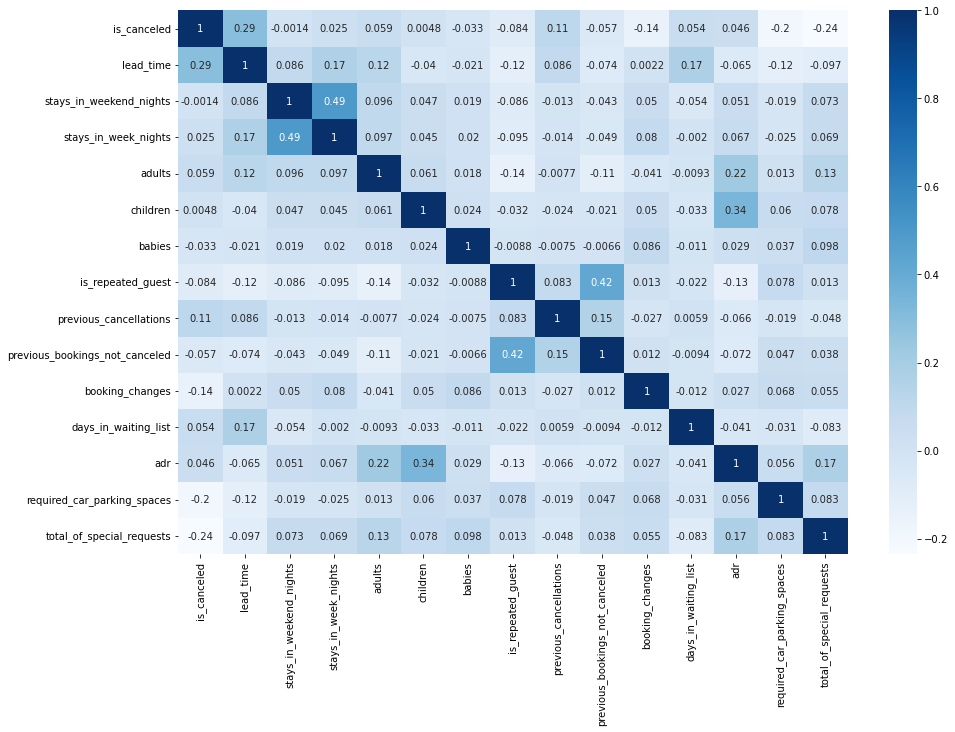

In [12]:
# Mapa de calor com correla√ß√£o entre todas as vari√°veis
plt.figure(figsize = (15,10))
sns.heatmap(df.corr(), annot = True, cmap = 'Blues')

In [13]:
# Coeficiente de correla√ß√£o da vari√°vel target 'is_canceled' com o restante das features
correlacao = df.corr()['is_canceled'].abs().sort_values(ascending = False)
correlacao

is_canceled                       1.000000
lead_time                         0.292983
total_of_special_requests         0.235262
required_car_parking_spaces       0.195863
booking_changes                   0.144863
previous_cancellations            0.110222
is_repeated_guest                 0.083797
adults                            0.058891
previous_bookings_not_canceled    0.057413
days_in_waiting_list              0.054357
adr                               0.046460
babies                            0.032620
stays_in_week_nights              0.025348
children                          0.004837
stays_in_weekend_nights           0.001388
Name: is_canceled, dtype: float64

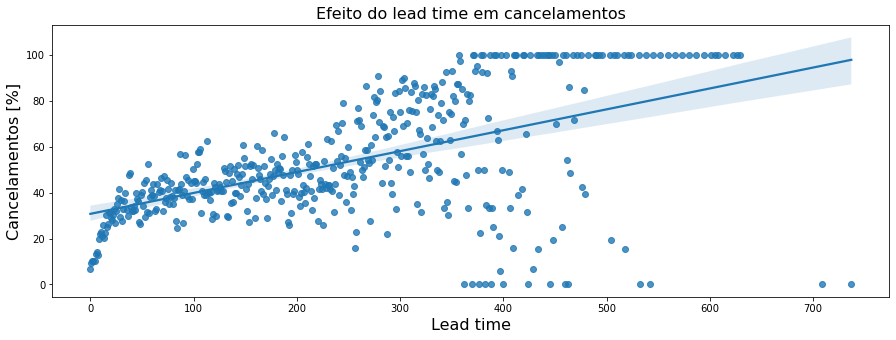

In [14]:
# Efeito do lead time em cancelamentos
lead_time_cancel = df.groupby("lead_time")['is_canceled'].describe()

# gr√°fico
plt.figure(figsize=(15, 5))
sns.regplot(x=lead_time_cancel.index, y=lead_time_cancel["mean"].values * 100)
plt.title("Efeito do lead time em cancelamentos", fontsize=16)
plt.xlabel("Lead time", fontsize=16)
plt.ylabel("Cancelamentos [%]", fontsize=16)
plt.show()

A partir do mapa de calor √© poss√≠vel ter **maior entendimento sobre como as vari√°veis se comportam entre si**.

Um insight retirado daqui, por exemplo, √© que **a feature com maior grau de rela√ß√£o com o fato de uma reserva ser cancelada ou n√£o √© a de "lead_time"**, ou seja, quanto maior o tempo existente entre a reserva do hotel at√© a data de chegada no mesmo, maior a probabilidade de haver cancelamento.

No t√≥pico "Expectativas Inicias" desta documenta√ß√£o, tamb√©m foi pontuado o hist√≥rico de cancelamentos do cliente (coluna "previous_cancellations" no caso desse dataset) como um poss√≠vel fator significativo. Olhando a correla√ß√£o, √© poss√≠vel verificar que essa rela√ß√£o realmente √© v√°lida, apresentando um grau de rela√ß√£o de 11% com a var√≠avel target.

Se o mapa de calor apresentasse colunas com correla√ß√£o forte (pr√≥ximo de 1, por exemplo), provavelmente seria feita a exclus√£o de uma delas para n√£o enviesar o resultado do modelo.

Por outro lado, deve-se analisar com cuidado a utilidade de colunas com correla√ß√£o fraca (pr√≥ximo de 0) e, se for o caso, as mesmas devem ser exclu√≠das.

Colunas a serem retiradas do modelo:
- hotel: Como o estudo ser√° utilizado pela equipe comercial do Hurb, esta coluna ser√° retirada visto que o modelo deve ser aplic√°vel para todos os hot√©is do cat√°logo.
- country: Por se tratar de hot√©is Portugueses, n√£o temos um n√∫mero significativo de brasileiros registrados. Al√©m disso, assim como ocorre para a coluna 'hotel', manter a coluna 'country' compromete o fator de "generaliza√ß√£o" do modelo.
- assigned_room_type: Pois j√° existe a coluna "reserved_room_type", que √© similar, e que nos retorna o quarto que de fato foi reservado.
- days_in_waiting_list: a maior parte dos dados dessa coluna √© 0 (poucos dias de espera). Al√©m disso, acredita-se que o 'lead time' j√° seja uma feature mais efetiva para dura√ß√£o de processo.
- reservation_status: tem fun√ß√£o similar √† vari√°vel target.
- reservation_status_date: como a coluna "reservation_status" ser√° exclu√≠da, esta coluna tamb√©m perde seu valor.

OBS.: Foi considerada a concatena√ß√£o entre os valores das colunas 'children' e 'babies' nesse processo de feature engineering, visto que se avaliou uma poss√≠vel dificuldade do processo em diferenciar crian√ßas de beb√™s. Entretanto, a coluna resultante dessa soma apresentou um resultado ruim de correla√ß√£o com a vari√°vel target.

In [15]:
# Colunas a serem retiradas
colunas = ['hotel','country', 'assigned_room_type', 'days_in_waiting_list', 'reservation_status', 'reservation_status_date']
df.drop(colunas, axis = 1, inplace = True)

df.head()

is_canceled  lead_time  stays_in_weekend_nights  stays_in_week_nights  \
0            0        342                        0                     0   
1            0        737                        0                     0   
2            0          7                        0                     1   
3            0         13                        0                     1   
4            0         14                        0                     2   

   adults  children  babies meal market_segment distribution_channel  ...  \
0       2         0       0   BB         Direct               Direct  ...   
1       2         0       0   BB         Direct               Direct  ...   
2       1         0       0   BB         Direct               Direct  ...   
3       1         0       0   BB      Corporate            Corporate  ...   
4       2         0       0   BB      Online TA                TA/TO  ...   

   previous_cancellations  previous_bookings_not_canceled  reserved_room_type  \
0                       0                               0                   C   
1                       0                               0                   C   
2                       0                               0                   A   
3                       0                               0                   A   
4                       0                               0                   A   

  booking_changes  deposit_type customer_type   adr  \
0               3    No Deposit     Transient   0.0   
1               4    No Deposit     Transient   0.0   
2               0    No Deposit     Transient  75.0   
3               0    No Deposit     Transient  75.0   
4               0    No Deposit     Transient  98.0   

   required_car_parking_spaces  total_of_special_requests  data_chegada  
0                            0                          0      2015-7-1  
1                            0                          0      2015-7-1  
2                            0                          0      2015-7-1  
3                            0                          0      2015-7-1  
4                            0                          1      2015-7-1  

[5 rows x 21 columns]

Segue an√°lise de algumas vari√°veis categ√≥ricas com a vari√°vel target:

C:\Users\joaov\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


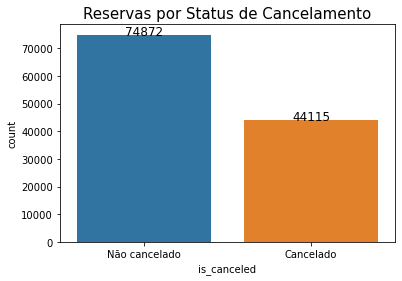

In [16]:
# Propor√ß√£o de reservas canceladas x n√£o canceladas
canceled_data = df['is_canceled']
plot = sns.countplot(canceled_data)
plt.title('Reservas por Status de Cancelamento', size=15)
ticks, labels = plt.xticks()
plt.xticks(ticks, labels=['N√£o cancelado', 'Cancelado'])
for i in plot.patches:
    plot.annotate(i.get_height(),
                 (i.get_x() + i.get_width() / 2, i.get_height()),
                 ha = 'center', va = 'baseline', fontsize=12,
                 )

plt.show()

Os hot√©is da base de dados apresentaram uma taxa de cancelamentos significativa, de 37% entre 2015 e 2017. Esse fato pode ter dificultado a opera√ß√£o dos hot√©is, por exemplo, no momento de dimensionar a log√≠stica de compra de comidas para as refei√ß√µes.

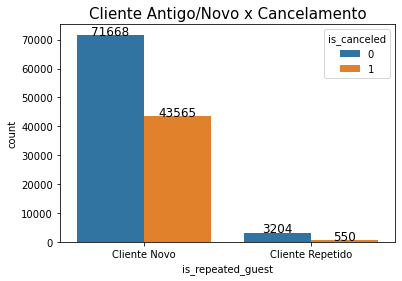

In [17]:
# Comportamento de clientes antigos com cancelamentos de reservas
plot = sns.countplot(data=df, x = 'is_repeated_guest', hue='is_canceled')
plt.title('Cliente Antigo/Novo x Cancelamento', size=15)
ticks, labels = plt.xticks()
plt.xticks(ticks, labels=['Cliente Novo', 'Cliente Repetido'])

for i in plot.patches:
    plot.annotate(i.get_height(),
                 (i.get_x() + i.get_width() / 2, i.get_height()),
                 ha = 'center', va = 'baseline', fontsize=12,
                 )

Clientes repetidos tem uma tend√™ncia menor em cancelar uma reserva (15%) quando comparado com novos clientes (37,5%).

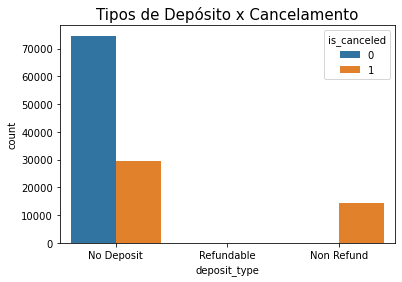

In [18]:
sns.countplot(data = df, x = 'deposit_type',hue='is_canceled')
plt.title('Tipos de Dep√≥sito x Cancelamento', size=15)

plt.show()

A informa√ß√£o sobre a exist√™ncia ou n√£o de um dep√≥sito para garantir a reserva parece ser bastante relevante para o modelo.

Quase a totalidade de casos de 'Non Refund' (quando √© feito um dep√≥sito no valor total do custo de estadia) possui a tend√™ncia em ser cancelado.

<a id = '3.5'></a>
#### 3.5 Tratamento de Outliers

<a id = '3.5.1'></a>
##### 3.5.1 M√©todo de Turkey para encontrar e tratar outliers de colunas num√©ricas

A partir do m√©todo de Turkey, ser√£o encontrados os limites inferiores e superiores da distribui√ß√£o de dados das features. Depois ser√° feita uma an√°lise em cima dos dados que estiverem abaixo do limite inferior (ùêøùëñùëõùëì = ùëÑ1 ‚àí (1.5 ‚àó ùêºùëÑùëÖ)) ou acima do limite superior (ùêøùë†ùë¢ùëù = ùëÑ3 + (1.5 ‚àó ùêºùëÑùëÖ)) e, se for o caso, os outliers ser√£o exclu√≠dos.

In [19]:
# Fun√ß√£o para definir os limites de uma coluna
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude # retornaremos o limite inferior e superior

# Fun√ß√£o que vai pegar os limites da fun√ß√£o anterior para excluir os outliers.
# Al√©m disso, retornar√° quantidade de linhas removidas pois se a quantidade for muito grande, pode afetar o modelo.
def excluir_outliers(df, nome_coluna): # df √© a base (dataframe)
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup) , :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df, linhas_removidas

In [20]:
# Fun√ß√£o para aplicar o boxplot e entender o comportamento das colunas
def diagrama_caixa(coluna):
    fig, (ax1,ax2) = plt.subplots(1,2) # ax1 √© eixo do 1¬∫ gr√°fico. ax2 √© eixo do 2¬∫ gr√°fico
    fig.set_size_inches(15,5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)

Tratamento das colunas com valores:
- lead_time
- stays_in_weekend_nights
- stays_in_week_nights
- adults
- children
- babies
- previous_cancellations
- previous_bookings_not_canceled
- booking_changes
- adr
- total_of_special_requests

C:\Users\joaov\AppData\Local\Temp/ipykernel_23712/4271549564.py:6: UserWarning: Attempting to set identical left == right == 2.0 results in singular transformations; automatically expanding.
  ax2.set_xlim(limites(coluna))
C:\Users\joaov\AppData\Local\Temp/ipykernel_23712/4271549564.py:6: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax2.set_xlim(limites(coluna))
C:\Users\joaov\AppData\Local\Temp/ipykernel_23712/4271549564.py:6: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax2.set_xlim(limites(coluna))
C:\Users\joaov\AppData\Local\Temp/ipykernel_23712/4271549564.py:6: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax2.set_xlim(limites(coluna))
C:\Users\joaov\AppData\Local\Temp/ipykernel_23712/4271549564.py:6: UserWarning: Attempting to set identical 

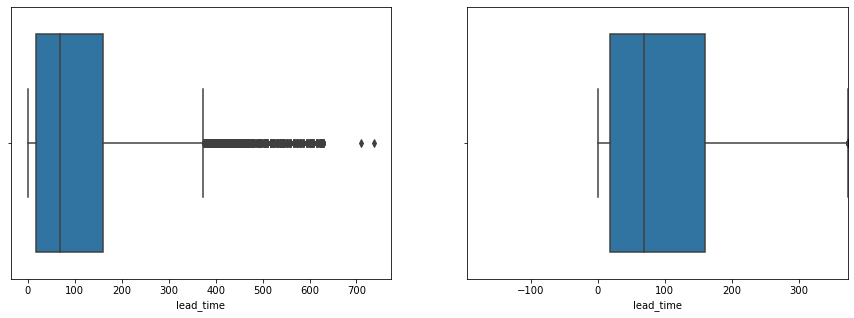

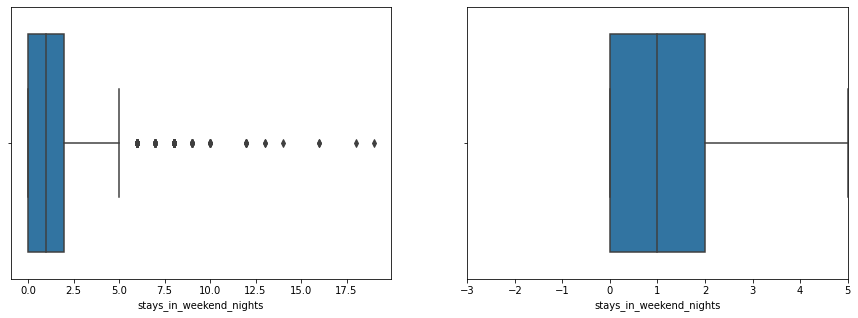

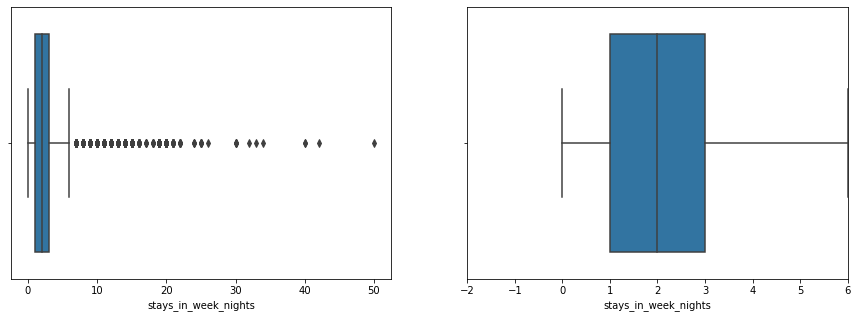

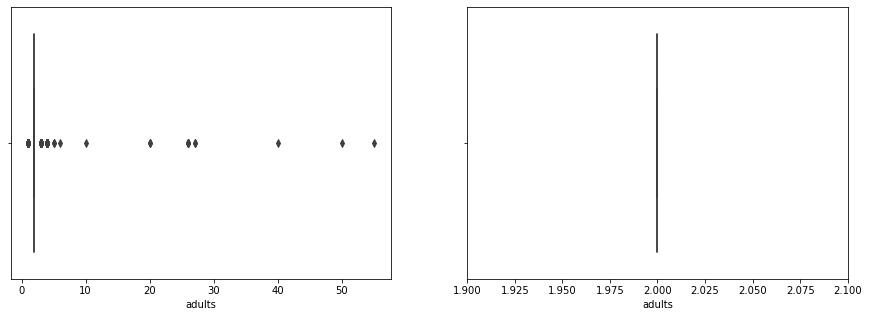

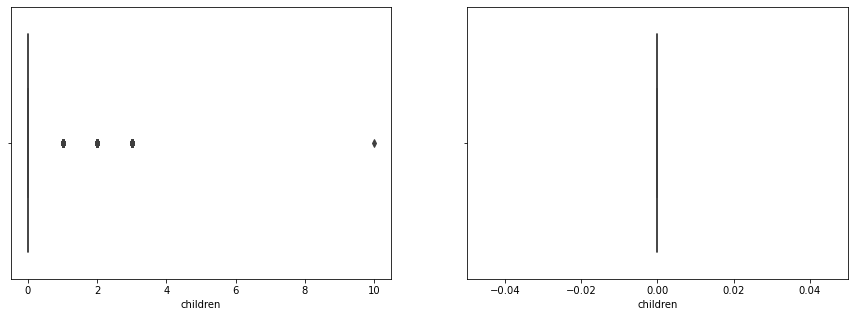

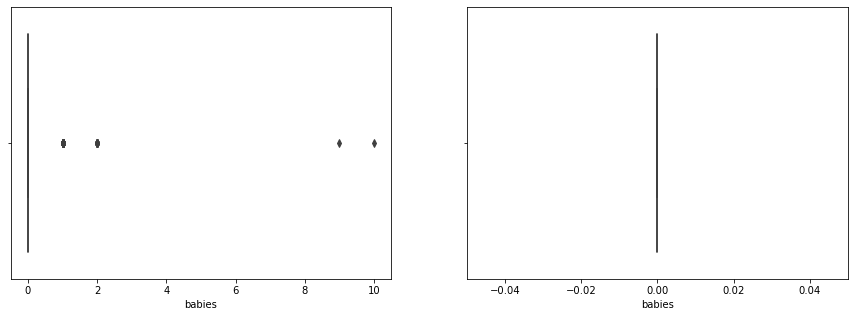

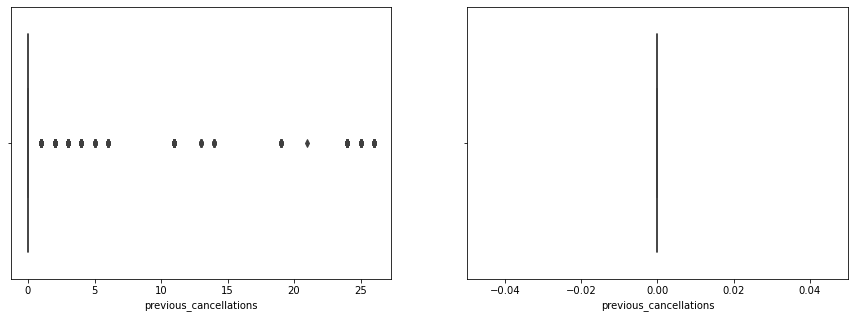

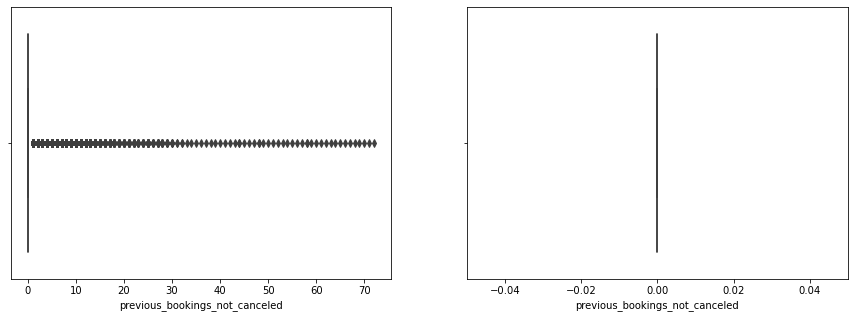

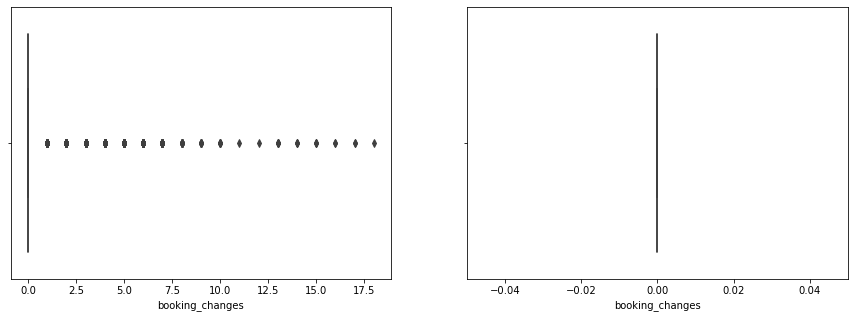

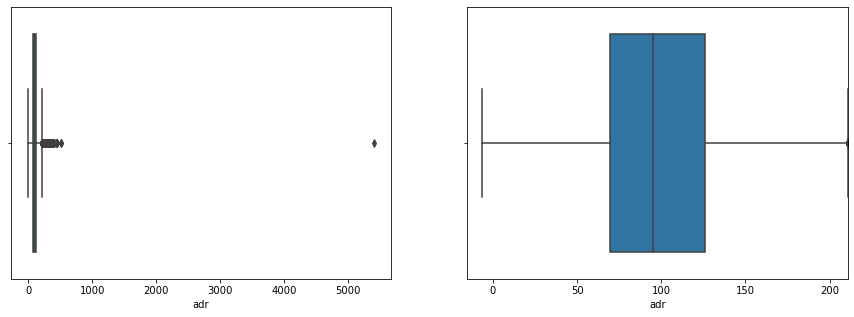

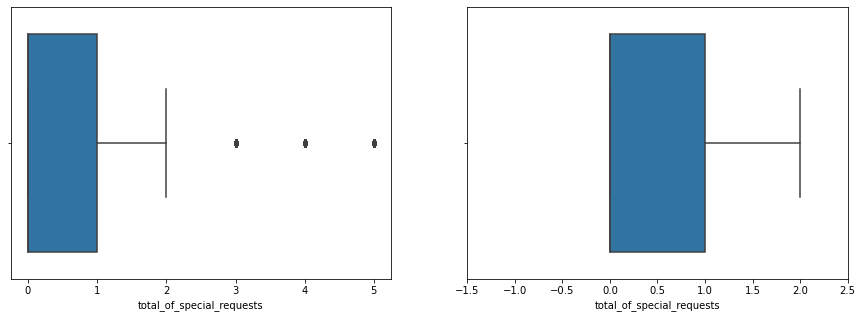

In [21]:
col_valores = ['lead_time','stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'adr', 'total_of_special_requests']

for i in col_valores:
    diagrama_caixa(df[i])

A partir dos gr√°ficos de boxplot acima, √© poss√≠vel notar que existem **colunas com limite inferior e superior iguais**: adults, children, babies, previous_cancelations, previous_bookings_not_canceled, booking_changes.

A retirada de outliers dessas colunas faria com que elas perdessem o sentido no modelo, visto que ter apenas um valor na coluna apenas enviesaria a previs√£o. Em contrapartida, tamb√©m n√£o pretendo excluir essas colunas visto que todas apresentam correla√ß√£o significativa com a vari√°vel target. Assim, deixarei essas colunas intactas.

Quanto √†s outras colunas, todas possuem limites inferiores abaixo de 0. Como tais colunas possuem valores positivos, ser√£o apenas retirados outliers acima do limite superior.

In [22]:
# Colunas com limite inferior e superior iguais

print("Limite da coluna 'adults':{}".format(limites(df['adults'])))
print("Limite da coluna 'children': {}".format(limites(df['children'])))
print("Limite da coluna 'babies': {}".format(limites(df['babies'])))
print("Limite da coluna 'previous_cancellations': {}".format(limites(df['previous_cancellations'])))
print("Limite da coluna 'previous_bookings_not_canceled': {}".format(limites(df['previous_bookings_not_canceled'])))
print("Limite da coluna 'booking_changes': {}".format(limites(df['booking_changes'])))

Limite da coluna 'adults':(2.0, 2.0)
Limite da coluna 'children': (0.0, 0.0)
Limite da coluna 'babies': (0.0, 0.0)
Limite da coluna 'previous_cancellations': (0.0, 0.0)
Limite da coluna 'previous_bookings_not_canceled': (0.0, 0.0)
Limite da coluna 'booking_changes': (0.0, 0.0)


In [23]:
# Limites das outras colunas

print("Limite da coluna 'lead_time':{}".format(limites(df['lead_time'])))
print("Limite da coluna 'stays_in_weekend_nights':{}".format(limites(df['stays_in_weekend_nights'])))
print("Limite da coluna 'stays_in_week_nights':{}".format(limites(df['stays_in_week_nights'])))
print("Limite da coluna 'adr':{}".format(limites(df['adr'])))
print("Limite da coluna 'total_of_special_requests':{}".format(limites(df['total_of_special_requests'])))

Limite da coluna 'lead_time':(-195.0, 373.0)
Limite da coluna 'stays_in_weekend_nights':(-3.0, 5.0)
Limite da coluna 'stays_in_week_nights':(-2.0, 6.0)
Limite da coluna 'adr':(-15.25, 210.75)
Limite da coluna 'total_of_special_requests':(-1.5, 2.5)


In [24]:
# Retirando outliers da coluna 'lead_time'
df, qtde_linhas_removidas = excluir_outliers(df,'lead_time')
print('{} linhas removidas'.format(qtde_linhas_removidas))

3003 linhas removidas


In [25]:
# Retirando outliers da coluna 'stays_in_weekend_nights'
df, qtde_linhas_removidas = excluir_outliers(df,'stays_in_weekend_nights')
print('{} linhas removidas'.format(qtde_linhas_removidas))

255 linhas removidas


In [26]:
# Retirando outliers da coluna 'stays_in_week_nights'
df, qtde_linhas_removidas = excluir_outliers(df,'stays_in_week_nights')
print('{} linhas removidas'.format(qtde_linhas_removidas))

3039 linhas removidas


In [27]:
# Retirando outliers da coluna 'adr'
df, qtde_linhas_removidas = excluir_outliers(df,'adr')
print('{} linhas removidas'.format(qtde_linhas_removidas))

3556 linhas removidas


In [28]:
# Retirando outliers da coluna 'total_of_special_requests'
df, qtde_linhas_removidas = excluir_outliers(df,'total_of_special_requests')
print('{} linhas removidas'.format(qtde_linhas_removidas))

2537 linhas removidas


In [29]:
# Nova estrutura de linhas e colunas do dataframe
df.shape

(106597, 21)

<a id = '3.5.2'></a>
##### 3.5.2 Colunas com texto/categ√≥ricas

In [30]:
# Quantidade de categorias existentes por coluna
a = df.select_dtypes(object).columns
for i in a:
    print (i, df[i].nunique())

meal 5
market_segment 8
distribution_channel 5
reserved_room_type 9
deposit_type 3
customer_type 4
data_chegada 793


In [31]:
# Divindo a coluna de 'data_chegada' em ano, m√™s e dia.
# Ser√° feito isso para diminuir o peso de uma √∫nica feature, reduzindo a complexidade do modelo.

df['data_chegada'] = pd.to_datetime(df['data_chegada'])

df['ano_chegada'] = df['data_chegada'].dt.year
df['mes_chegada'] = df['data_chegada'].dt.month
df['dia_chegada'] = df['data_chegada'].dt.day

df.drop(['data_chegada'], axis=1, inplace=True)

In [32]:
# Usando o LabelEncoder para padronizar a escala de n√∫meros utilizada nas colunas de data
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

df['ano_chegada'] = le.fit_transform(df['ano_chegada'])
df['mes_chegada'] = le.fit_transform(df['mes_chegada'])
df['dia_chegada'] = le.fit_transform(df['dia_chegada'])

In [33]:
# Colunas de categoria do dataset
txt_cols = df.select_dtypes(object).columns

for i in txt_cols:
    print(f"{i}: {df[i].unique()}\n")

meal: ['BB' 'FB' 'HB' 'SC' 'Undefined']

market_segment: ['Direct' 'Corporate' 'Online TA' 'Offline TA/TO' 'Complementary' 'Groups'
 'Undefined' 'Aviation']

distribution_channel: ['Direct' 'Corporate' 'TA/TO' 'Undefined' 'GDS']

reserved_room_type: ['C' 'A' 'D' 'E' 'G' 'F' 'H' 'L' 'B']

deposit_type: ['No Deposit' 'Refundable' 'Non Refund']

customer_type: ['Transient' 'Contract' 'Transient-Party' 'Group']



Para codificar essas colunas de texto, ser√° usado o m√©todo do ONE HOT ENCODER, que √© similar ao LabelEncoder, por√©m divide as colunas em v√°rias outras que representam suas categorias. Essas colunas ser√£o preenchidas apenas com 0 ou 1.

In [34]:
# Criando uma c√≥pia do dataframe original
df_encod = df.copy()

# Encoding a partir do m√©todo de vari√°veis dummies
df_encod = pd.get_dummies(data = df_encod, columns = txt_cols)
df_encod.head()

is_canceled  lead_time  stays_in_weekend_nights  stays_in_week_nights  \
0            0        342                        0                     0   
2            0          7                        0                     1   
3            0         13                        0                     1   
4            0         14                        0                     2   
5            0         14                        0                     2   

   adults  children  babies  is_repeated_guest  previous_cancellations  \
0       2         0       0                  0                       0   
2       1         0       0                  0                       0   
3       1         0       0                  0                       0   
4       2         0       0                  0                       0   
5       2         0       0                  0                       0   

   previous_bookings_not_canceled  ...  reserved_room_type_G  \
0                               0  ...                     0   
2                               0  ...                     0   
3                               0  ...                     0   
4                               0  ...                     0   
5                               0  ...                     0   

   reserved_room_type_H  reserved_room_type_L  deposit_type_No Deposit  \
0                     0                     0                        1   
2                     0                     0                        1   
3                     0                     0                        1   
4                     0                     0                        1   
5                     0                     0                        1   

   deposit_type_Non Refund  deposit_type_Refundable  customer_type_Contract  \
0                        0                        0                       0   
2                        0                        0                       0   
3                        0                        0                       0   
4                        0                        0                       0   
5                        0                        0                       0   

   customer_type_Group  customer_type_Transient  customer_type_Transient-Party  
0                    0                        1                              0  
2                    0                        1                              0  
3                    0                        1                              0  
4                    0                        1                              0  
5                    0                        1                              0  

[5 rows x 51 columns]

<a id = '4.0'></a>
### 4. Modelo de Previs√£o

<a id = '4.1'></a>
#### 4.1 Estruturando o Modelo

In [35]:
# Extraindo a vari√°vel target do modelo
X = df_encod.drop('is_canceled', axis = 1)
y = df_encod['is_canceled']

X.shape, y.shape

((106597, 50), (106597,))

In [36]:
# Separando conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

Os dados apresentam uma diferen√ßa significante de escala entre si. Para evitar que uma feature seja predominante sobre outra, aplicarei uma t√©cnica de Feature Scalling chamada Standardization (Normaliza√ß√£o).

Neste m√©todo, os dados ser√£o redimensionados, garantindo que eles fiquem em formato de curva Gaussiana.

In [37]:
# Feature Scalling
scaler = StandardScaler().fit(df[col_valores])
scaler.transform(df[col_valores])
df[col_valores] = scaler.transform(df[col_valores])

O objetivo deste modelo √© prever se uma reserva ser√° ou n√£o cancelada.

Portanto, os algor√≠tmos de machine learning a serem utilizados s√£o:
- Logistic Regression
- Decision Tree
- Random Forest
- XGBoost

In [38]:
modelo_lr = LogisticRegression()
modelo_rf = RandomForestClassifier()
modelo_dt = DecisionTreeClassifier()
modelo_xgb = XGBClassifier()

modelos = {'Logistic Regression': modelo_lr,
          'Random Forest': modelo_rf,
          'Decision Tree': modelo_dt,
          'XGBoost': modelo_xgb}

<a id = '4.2'></a>
#### 4.2 Gerando a previs√£o

Ao passo que todos os 4 algor√≠tmos s√£o treinados e testados, eles tamb√©m ser√£o avaliados em dois par√¢metros:
- Accuracy Score: precis√£o do modelo em acertar a previs√£o (previsao == y_test)
- Confusion Matrix: uma matriz que mostra a quantidade de previs√µes que retornaram verdadeiro positivo/negativo e falso positivo/negativo.

In [39]:
for nome_modelo, modelo in modelos.items():
    # treinar/fit:
    modelo.fit(X_train, y_train)
    # testar/predict:
    previsao = modelo.predict(X_test)
    acc = accuracy_score(y_test, previsao)
    conf = confusion_matrix(y_test, previsao)
    print(f"Precis√£o do {nome_modelo}: {acc}")
    print(f"Confusion Matrix {nome_modelo}: \n{conf}\n")

C:\Users\joaov\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Precis√£o do Logistic Regression: 0.7984615384615384
Confusion Matrix Logistic Regression: 
[[15646  1184]
 [ 4187  5633]]

Precis√£o do Random Forest: 0.8639774859287055
Confusion Matrix Random Forest: 
[[15723  1107]
 [ 2518  7302]]

Precis√£o do Decision Tree: 0.8216135084427767
Confusion Matrix Decision Tree: 
[[14413  2417]
 [ 2337  7483]]

Precis√£o do XGBoost: 0.8383114446529081
Confusion Matrix XGBoost: 
[[15590  1240]
 [ 3069  6751]]



O modelo com melhor nota de precis√£o foi o Random Forest, com cerca de 86% de accuracy score.

Para efeito de melhor visualiza√ß√£o, segue um plot exemplo de √°rvore de decis√£o feita pelo Random Forest. Ser√£o plotadas apenas 3 camadas da √°rvore por conta da quantidade de features existentes no modelo.

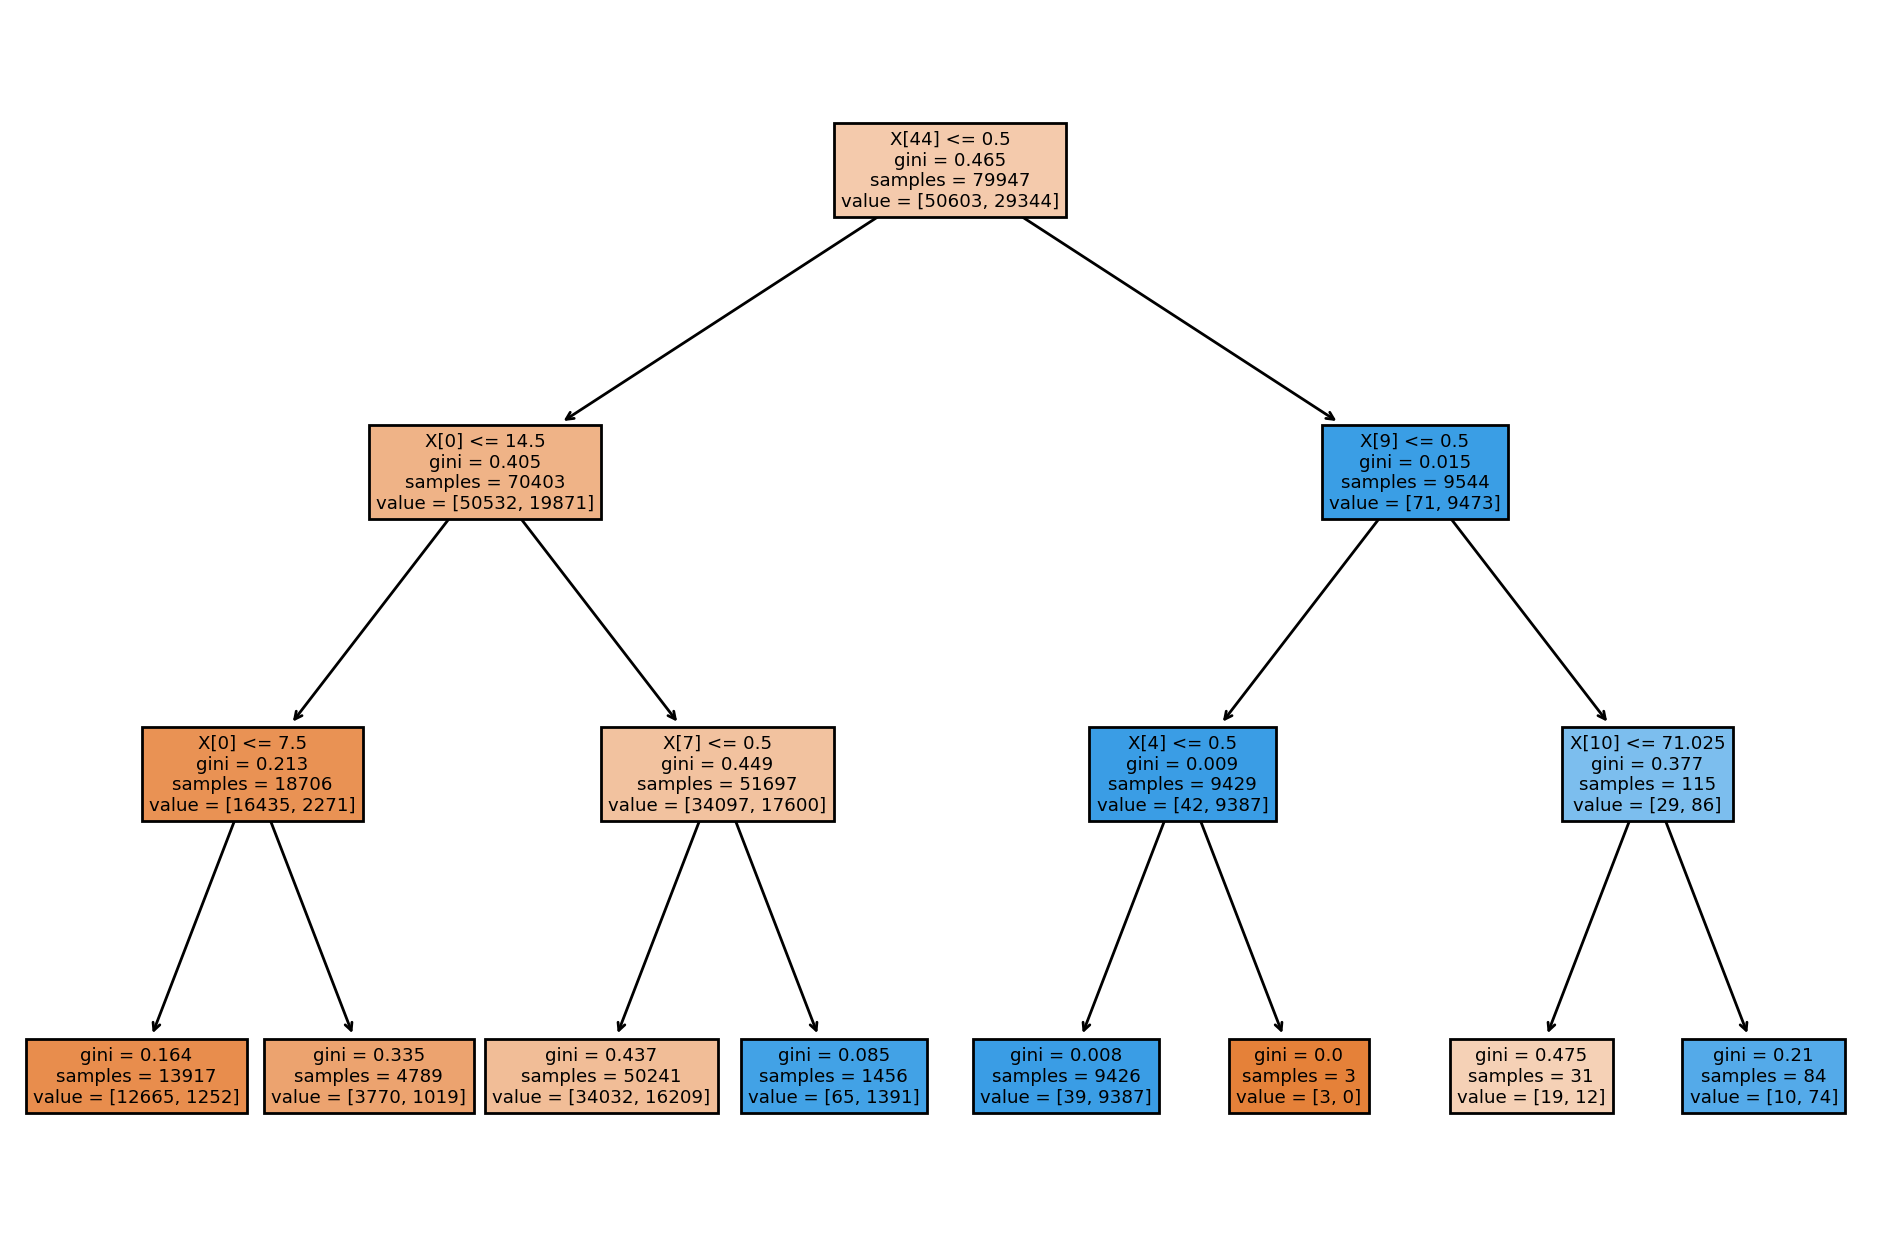

In [40]:
from sklearn.tree import plot_tree

plt.figure(figsize=(12,8), dpi=200)

pruned_dtc = DecisionTreeClassifier(max_depth=3)
pruned_dtc.fit(X_train, y_train)
y_pred_dtc = pruned_dtc.predict(X_test)

plot_tree(pruned_dtc, filled = True);

<a id='4.3'></a>
#### 4.3 Avalia√ß√£o de import√¢ncia das features

Com a fun√ß√£o **feature_importances_** √© poss√≠vel avaliar o quanto cada feature do modelo √© √∫til em prever a vari√°vel target.

Esta avalia√ß√£o √© um passo importante para o modelo pois fornece insights sobre os dados e o modelo que tem-se em m√£os.

Dependendo do resultado, √© poss√≠vel retornar √† etapa de feature engineering, e reduzir vari√°veis que n√£o possuem tanta import√¢ncia, em prol de obter uma maior efici√™ncia ao rodar o modelo.

0
lead_time                       0.166252
adr                             0.115073
dia_chegada                     0.089694
deposit_type_Non Refund         0.084204
deposit_type_No Deposit         0.083056
mes_chegada                     0.059072
total_of_special_requests       0.055719
stays_in_week_nights            0.045697
previous_cancellations          0.040863
stays_in_weekend_nights         0.028541
ano_chegada                     0.023126
booking_changes                 0.022145
required_car_parking_spaces     0.020392
market_segment_Online TA        0.020231
adults                          0.016054
customer_type_Transient         0.013094
market_segment_Offline TA/TO    0.012691
market_segment_Groups           0.012096
customer_type_Transient-Party   0.011645
distribution_channel_TA/TO      0.009151
reserved_room_type_A            0.007183
children                        0.006569
meal_BB                         0.006363
reserved_room_type_D            0.006082
meal_HB                         0.005032
distribution_channel_Direct     0.004374
market_segment_Direct           0.004097
previous_bookings_not_canceled  0.004097
reserved_room_type_E            0.004012
meal_SC                         0.003541
distribution_channel_Corporate  0.002489
market_segment_Corporate        0.002152
is_repeated_guest               0.002009
reserved_room_type_F            0.001794
customer_type_Contract          0.001618
meal_FB                         0.001461
reserved_room_type_G            0.001378
reserved_room_type_B            0.001365
reserved_room_type_C            0.001179
babies                          0.001043
meal_Undefined                  0.000889
reserved_room_type_H            0.000539
customer_type_Group             0.000430
deposit_type_Refundable         0.000430
market_segment_Complementary    0.000361
market_segment_Aviation         0.000301
distribution_channel_GDS        0.000293
distribution_channel_Undefined  0.000073
reserved_room_type_L            0.000029
market_segment_Undefined        0.000023

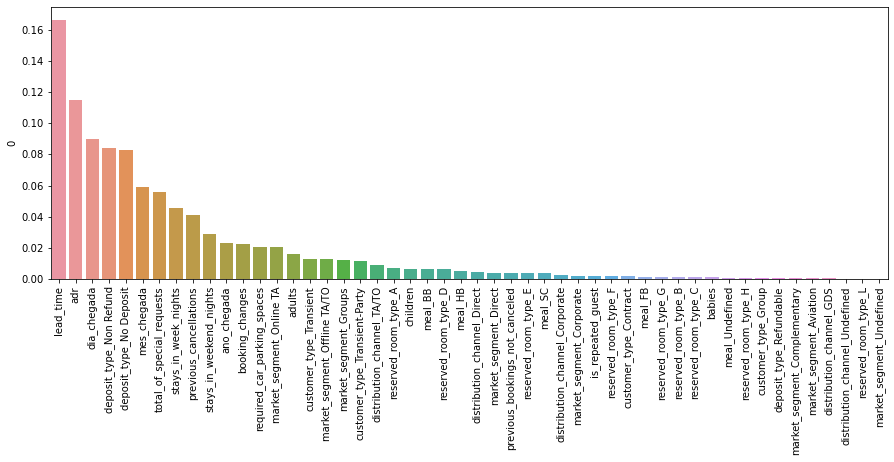

In [41]:
importancia_features = pd.DataFrame(modelo_rf.feature_importances_, X_train.columns)
importancia_features = importancia_features.sort_values(by=0, ascending=False)
display(importancia_features)

plt.figure(figsize=(15, 5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features[0])
ax.tick_params(axis='x', rotation=90)

Certas features, como era esperado, tiveram import√¢ncia relevante no modelo, como: lead time, adr e o tipo de dep√≥sito.

Por outro lado, existem features no modelo com um grau de relev√¢ncia abaixo de 0,1%. A princ√≠pio, n√£o farei o descarte dessas features por√©m, se a base de dados fosse maior e/ou o modelo menos eficiente, eu provavelmente teria de olhar com cuidado a viabilidade de se manter essas colunas no modelo.

<a id = '5.0'></a>
### 5. Considera√ß√µes Finais

A partir da explora√ß√£o de dados do modelo foi poss√≠vel verificar que a taxa de reservas que s√£o canceladas √© consideravelmente alta (37%). Como a motiva√ß√£o da equipe comercial tamb√©m √© formular melhores estrat√©gias comeciais para lidar com cancelamentos, uma dica seria dar maior aten√ß√£o √†s vari√°veis mais importantes. Como por exemplo:
- O **'lead_time'** poderia ser reduzido se os hot√©is limitassem o qu√£o para o futuro uma reserva pode ser feita.
- Quanto ao **'adr'**, um estudo de mercado para entender o pre√ßo da di√°ria praticado por outros hot√©is poderia ajudar a entender se o pre√ßo atual est√° fazendo sentido.
- Percebe-se que, quanto mais personalizada for a estadia **('total_of_special_requests')**, menor a chance de cancelamento. Portanto, um modelo de neg√≥cio que d√™ mais foco em estadias personalizadas tamb√©m poderia ser ben√©fico.

De qualquer forma, em qualquer melhoria de processo, **este modelo n√£o deve ser usado como √∫nica fonte de informa√ß√£o**. Sugere-se que outras informa√ß√µes como o balan√ßo financeiro, log√≠stica e suprimentos tamb√©m sejam analisadas em conjuntos para a tomada de decis√£o. 

Por fim, com a aplica√ß√£o deste modelo, conseguiremos prever com **86%** de acur√°cia se as reservas feitas ser√£o canceladas ou n√£o, o que ajudar√° a equipe comercial a direcionar de forma mais eficiente seus esfor√ßos.